In [18]:
import pyarrow.parquet as pq
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

In [64]:
df = pq.read_table(source='D:/mashob/0_processed.parquet').to_pandas()

In [65]:
df.head(3)

,title,text_markdown,pluses,minuses,id,tags
0,купить китай цена новое iphone pro,осень россия стартовать продажа очередной моде...,9,13,6991642,Китай;AliExpress;Китайские товары;Бизнес;Длинн...
1,последний оставаться живой освободитель освенц...,канун освобождение концлагерь v всемирный фору...,1498,159,7178566,Великая Отечественная война;Чтобы помнили;Осве...
2,зима тюмень приходить,честь сочинять свой первый пирожок приходить з...,517,64,7021067,Стишки-Пирожки;Снег;Тюмень;Мат


# Create column rating

In [66]:
df['rating'] = df['pluses'] - df['minuses']
df_rate = df.drop(columns=['pluses','minuses'])
df_rate.head(3)

,title,text_markdown,id,tags,rating
0,купить китай цена новое iphone pro,осень россия стартовать продажа очередной моде...,6991642,Китай;AliExpress;Китайские товары;Бизнес;Длинн...,-4
1,последний оставаться живой освободитель освенц...,канун освобождение концлагерь v всемирный фору...,7178566,Великая Отечественная война;Чтобы помнили;Осве...,1339
2,зима тюмень приходить,честь сочинять свой первый пирожок приходить з...,7021067,Стишки-Пирожки;Снег;Тюмень;Мат,453


Text(0, 0.5, 'Number of posts')

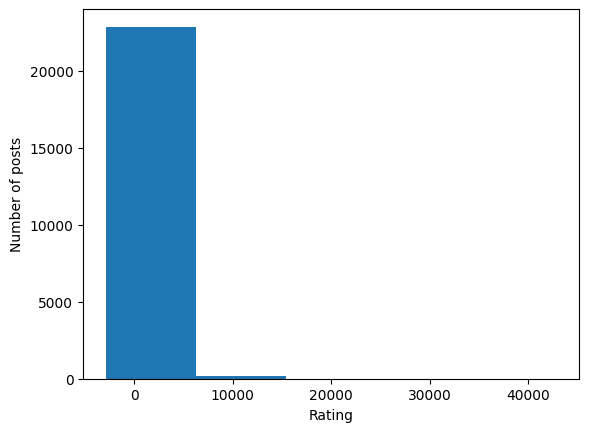

In [67]:
plt.hist(df_rate['rating'], bins=5)
plt.xlabel('Rating')
plt.ylabel('Number of posts')

In [103]:
min_rate = df_rate.rating.min()
max_rate = df_rate.rating.max()
print('Min rate:', min_rate)
print('Max rate:', max_rate)

Min rate: -2882
Max rate: 42896


In [172]:
def create_label(left_border, right_border):
    intervals = np.linspace(left_border, right_border, endpoint=True, num=6)
    intervals[0] = -np.inf
    intervals[-1] = np.inf
    df_rate["label"] = pd.cut(df_rate.rating, intervals, labels=False, include_lowest=True)
    return intervals

In [270]:
intervals = create_label(df_rate["rating"].min(), df_rate["rating"].max())

смотрим на распределение

In [271]:
df_rate.label.value_counts()

label
0    22842
1      152
2        5
4        1
Name: count, dtype: int64

Поскольку количество элементов, попавших в интервалы 1-4, намного меньше, правую границу можно сдвинуть в пределы нулевого интервала

In [272]:
intervals_double = create_label(df_rate["rating"].min(), intervals[1])

In [286]:
df_rate.label.value_counts()

label
1    21221
2      785
4      585
3      394
0       15
Name: count, dtype: int64

сдвигаем левую границу

In [288]:
intervals_third = create_label(intervals_double[1], intervals[1])

In [284]:
intervals_double[1], intervals[1]

(-1050.8799999999999, 6273.6)

In [280]:
df_rate.label.value_counts()

label
0    20616
1     1571
2      433
4      236
3      144
Name: count, dtype: int64

In [281]:
df_rate.label.count() == n_post

True

Получили следующие интервалы меток относительно рейтинга

In [282]:
for i in range(intervals_third.shape[0]-1):
    print(f'{i}-st label:', 'from', np.round(intervals_third[i]), 'to', np.round(intervals_third[i+1]))

0-st label: from -inf to 414.0
1-st label: from 414.0 to 1879.0
2-st label: from 1879.0 to 3344.0
3-st label: from 3344.0 to 4809.0
4-st label: from 4809.0 to inf


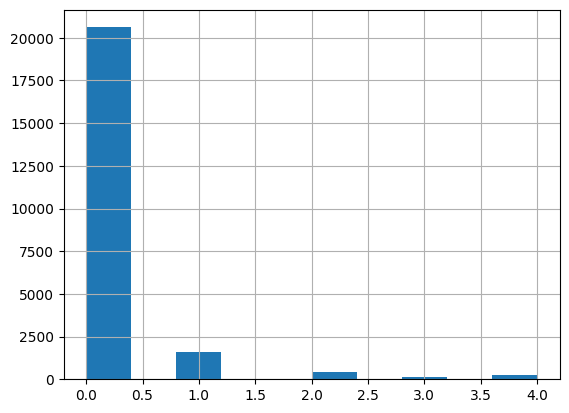

In [289]:
h = df_rate['label'].hist()
fig = h.get_figure()

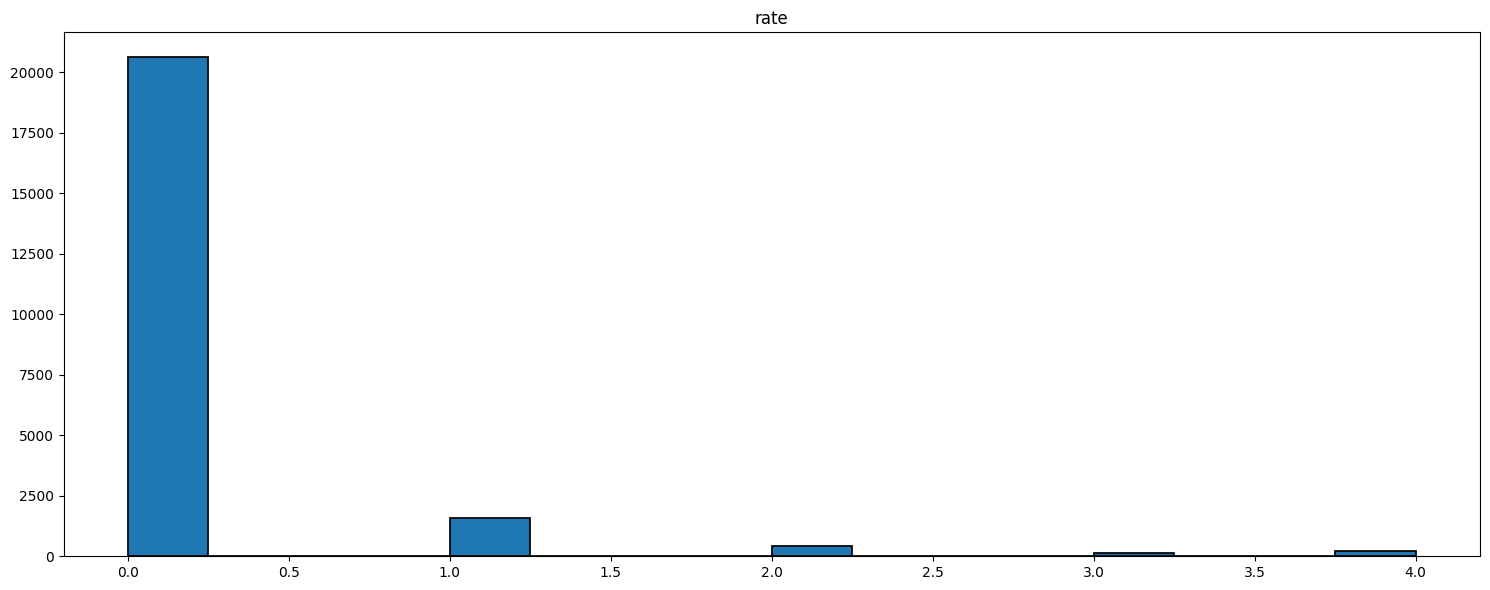

In [249]:
fig, axes = plt.subplots(1, 1, figsize=(15, 6))

sns.histplot(x="label", data=df_rate, linewidth=1.25,
             alpha=1, ax=axes, zorder=2)
axes.set_title("rate")
axes.set(xlabel=None, ylabel=None)

plt.tight_layout()
plt.show()

In [291]:
corpus = [str(df_rate['text_markdown'].to_list())]

In [292]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names_out()

array(['aaa', 'aac', 'aalto', ..., 'ящук', 'ящур', 'яя'], dtype=object)

# Tf-idf. LogRess

In [304]:
from sklearn.linear_model import LogisticRegression

In [295]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(df_rate.text_markdown, df_rate.label, test_size=0.2, random_state=42)


In [296]:
X_train_text = X_train.values
X_test_text = X_test.values
y_train = y_train.values
y_test = y_test.values

In [297]:
v = TfidfVectorizer(norm=None, max_df=0.8, max_features=500, decode_error='replace')
X_train_vector = v.fit_transform(X_train_text)
X_test_vector = v.transform(X_test_text)

In [298]:
clf = LogisticRegression( random_state=64, solver='lbfgs', max_iter=10000, n_jobs=-1) # Обучаем классификатор
clf.fit(X_train_vector, y_train)
y_pred = clf.predict(X_test_vector)

In [300]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [301]:
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

0.8736956521739131
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      4100
           1       0.20      0.02      0.04       327
           2       0.00      0.00      0.00        96
           3       0.00      0.00      0.00        31
           4       0.00      0.00      0.00        46

    accuracy                           0.87      4600
   macro avg       0.22      0.20      0.19      4600
weighted avg       0.81      0.87      0.84      4600



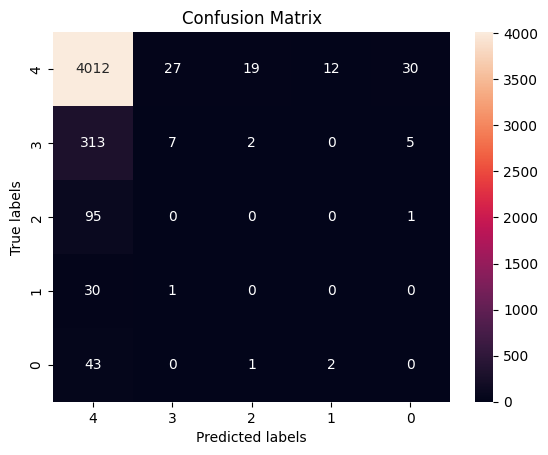

In [303]:
T5_lables = ['4','3','2','1','0']    

ax= plt.subplot()

cmm = confusion_matrix(y_test,y_pred)
sns.heatmap(cmm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);